# <h2 align="center">Cancer Diagnosis</h2>
## <h3 align="center">Malignant vs. Benign Tumors</h3>

---
### Description
The dataset used is authored by user Erdem Taha on Kaggle and contains
cancer diagnostic information for 569 patients.  The features show different
continuous attributes related to size, texture, smoothness, etc. that help to
 diagnose whether a tumor is benign or malignant.  The worst record, mean,
 and standard error of each feature are included.

#### Features
Mean, Standard Error, and Worst for the following:
- radius
- texture
- perimeter
- area
- smoothness
- compactness
- concavity
- concave points
- symmetry
- fractal dimension

All features, with the exception of `diagnosis`, are continuous

#### Uses
The primary use of this dataset is predicting the binary feature `diagnosis`.
  However, the dataset also lends itself to regression for null imputation or
   clustering for tumor subtype analysis.

---
## Data Preparation
The following data preparation steps and exploratory data analysis (EDA)
apply to all ML subtypes and are reused for each model technique

In [1]:
#Imports and Dataset
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub as kh
from kagglehub import KaggleDatasetAdapter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score,
                             mean_squared_error, r2_score, mean_absolute_error)
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from kneed import KneeLocator

#Load the dataset using kagglehub documentation
df = kh.dataset_load(
    KaggleDatasetAdapter.PANDAS,
  "erdemtaha/cancer-data",
    path='Cancer_Data.csv'
)

#Remove unnecessary columns
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

#Change diagnosis column to binary
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Save original dataframe for later use
original_df = df.copy()

In [2]:
#Custom Functions

#Box-Cox Transformation for DataFrames
def boxcox_transformation_dataframe(df, columns_to_transform):
    transformed_df = df.copy()
    for col in columns_to_transform:
        transformed_data, lmbda = stats.boxcox(df[col] + 1e-6)
        transformed_df[col] = transformed_data

    return transformed_df

#Box-Cox Transformation for Numpy Arrays
def boxcox_transformation_array(X, columns_to_transform):
    X = np.asarray(X).copy()
    for col_idx in columns_to_transform:
        X[:, col_idx], _ = stats.boxcox(X[:, col_idx] + 1e-6)

    return X

#Mahalanobis Distance Calculation
def mahalanobis_distance_prep(X, mean, cov):
    """Compute Mahalanobis distance for each row in X with respect to given mean and covariance."""
    X_mean = X - mean
    inv_cov = np.linalg.inv(cov + np.eye(
        cov.shape[0]) * 1e-6)  # Add small regularization term if needed
    left_term = np.dot(X_mean, inv_cov)
    mahal_d = np.sqrt(np.sum(left_term * X_mean, axis=1))
    return mahal_d

#Mahalanobis Distance Thresholds for Outliers
def mahalanobis_outlier_removal(X, threshold=0.99):
    outlier_mask = None
    X = np.asarray(X)

    # Compute Mahalanobis distance
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)

    X_centered = X - mean
    left = np.dot(X_centered, inv_cov)
    mahal = np.sqrt(np.sum(left * X_centered, axis=1))

    cutoff = np.sqrt(stats.chi2.ppf(threshold, X.shape[1]))
    mask = mahal < cutoff

    outlier_mask = mask  # Save externally for y alignment
    return X[mask], outlier_mask

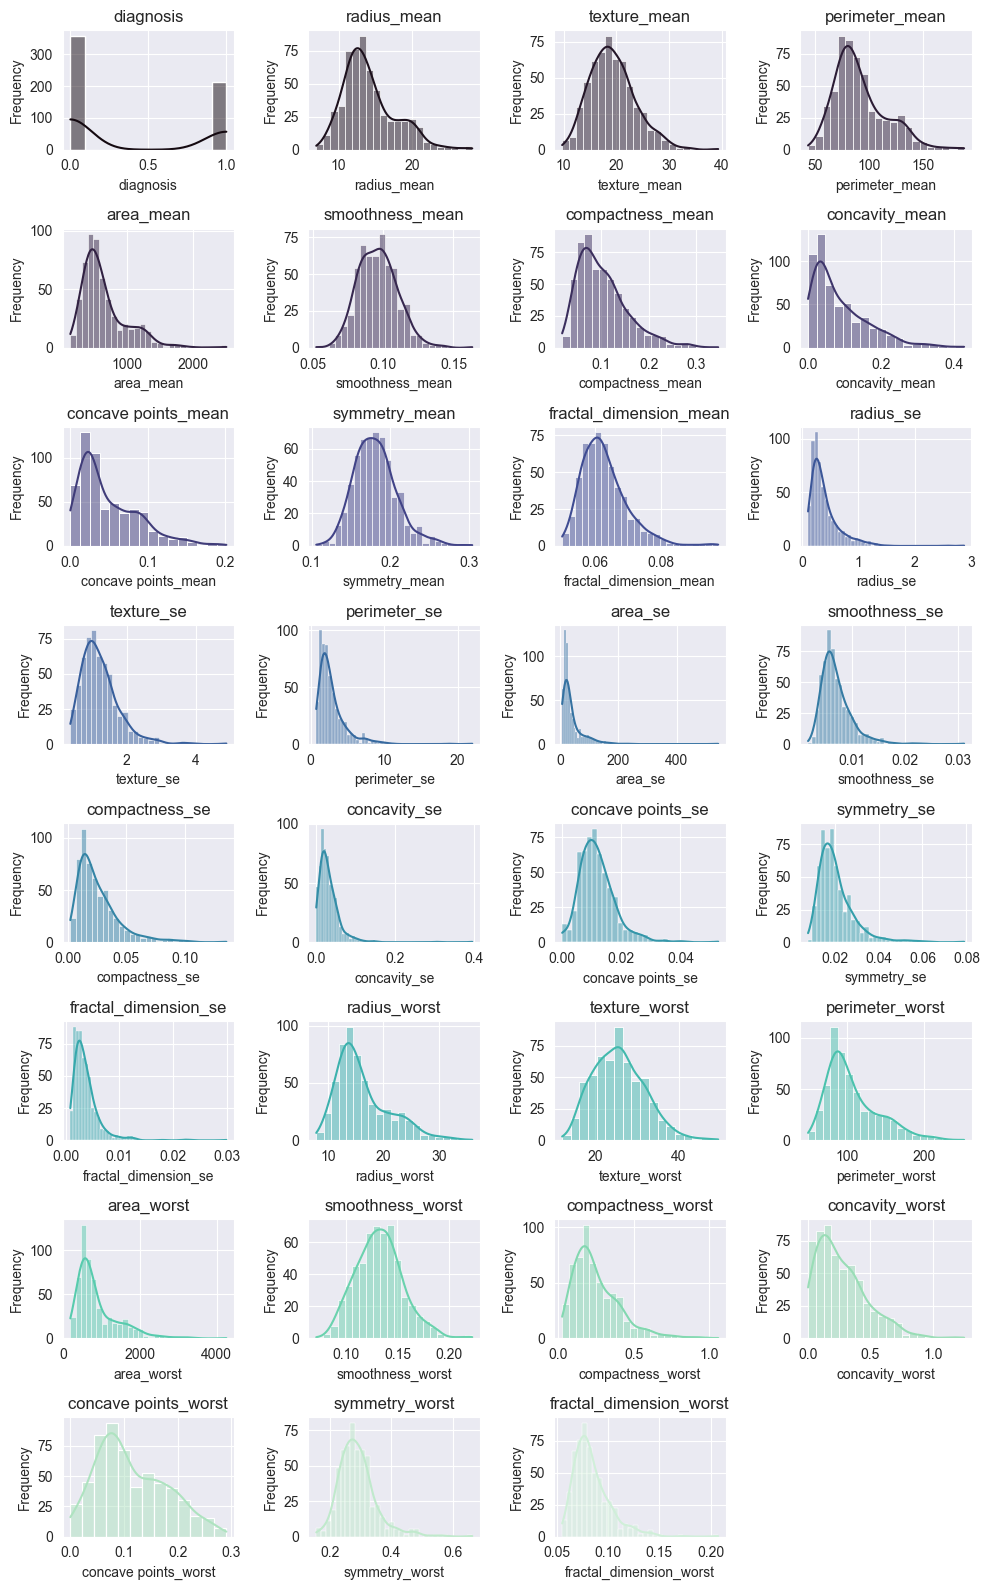

In [3]:
#Get Histograms of Original Data
columns = 4
rows = 8

colors = sns.color_palette("mako",
                           len(df.columns))

plt.figure(figsize=(columns*2.5, rows*2))

for i, (col, color) in enumerate(zip(df.columns, colors), 1):
    plt.subplot(rows, columns, i)
    sns.histplot(df[col], kde=True, color=color)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [4]:
#Transform Exponential Distributions using Box-Cox Transformation
expon_columns = [
    'radius_se',
    'perimeter_se',
    'area_se',
    'concavity_se',
    'concavity_mean',
    'concave points_mean',
    'fractal_dimension_se',
    'area_worst'
]

transformed_df = boxcox_transformation_dataframe(df, expon_columns)

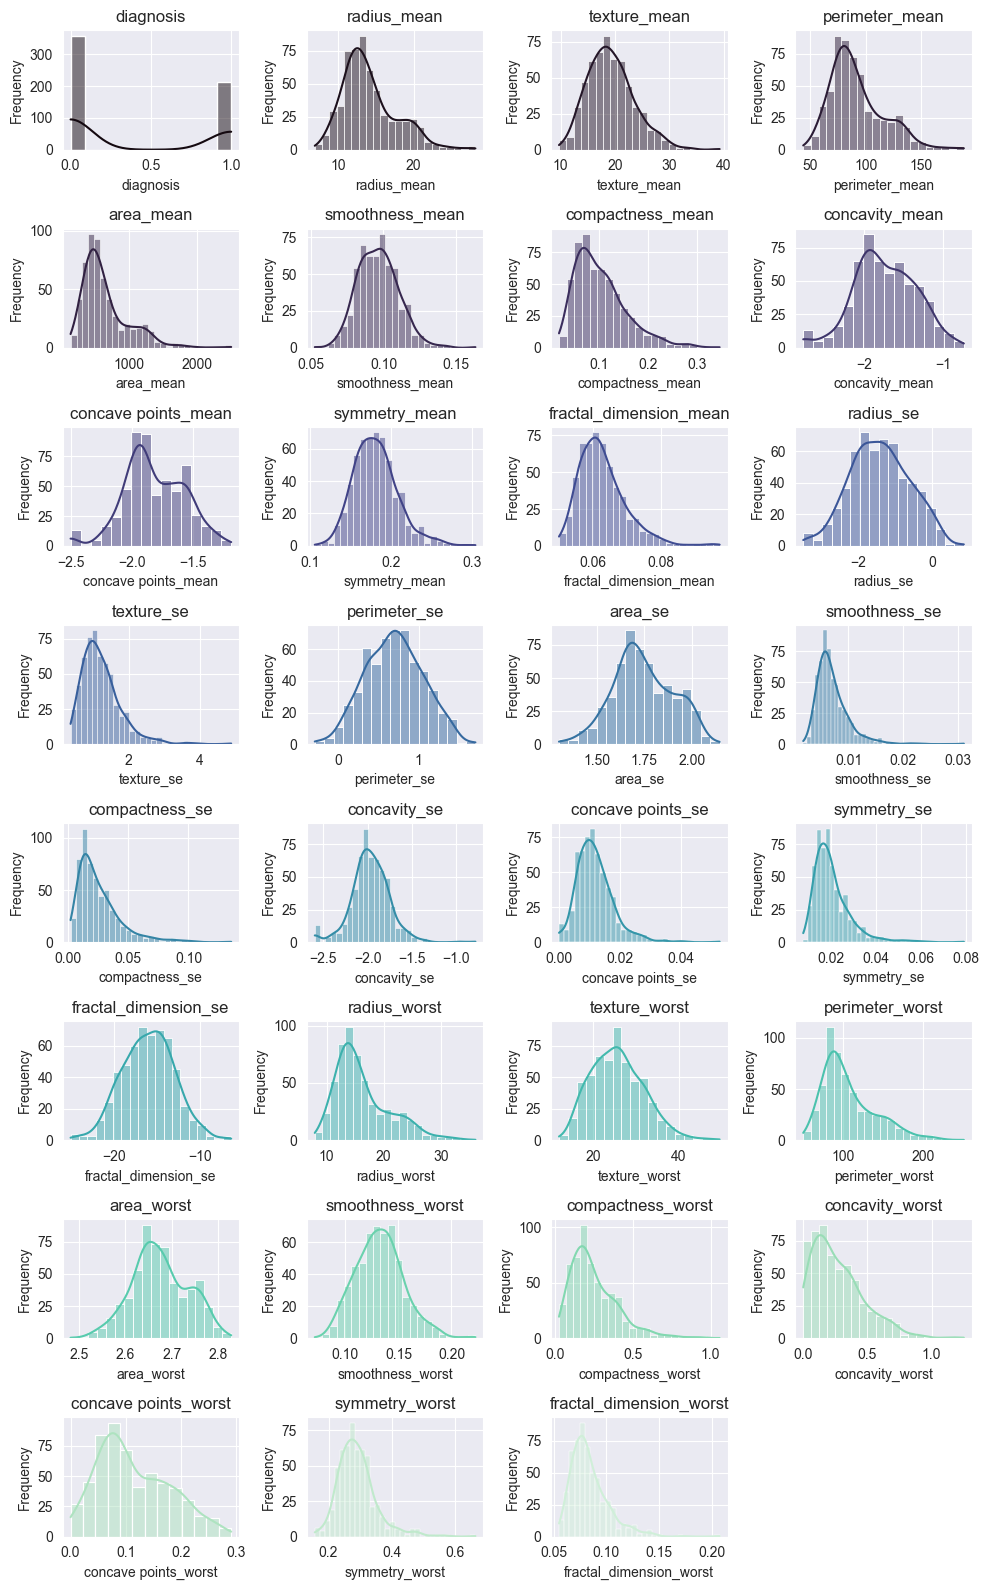

In [5]:
#Get Histograms of Transformed Data
columns = 4
rows = 8

plt.figure(figsize=(columns*2.5, rows*2))

for i, (col, color) in enumerate(zip(transformed_df.columns, colors), 1):
    plt.subplot(rows, columns, i)
    sns.histplot(transformed_df[col], kde=True, color=color)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
#Get the number of nulls in the dataset
df.isnull().sum().sort_values(ascending=False)

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

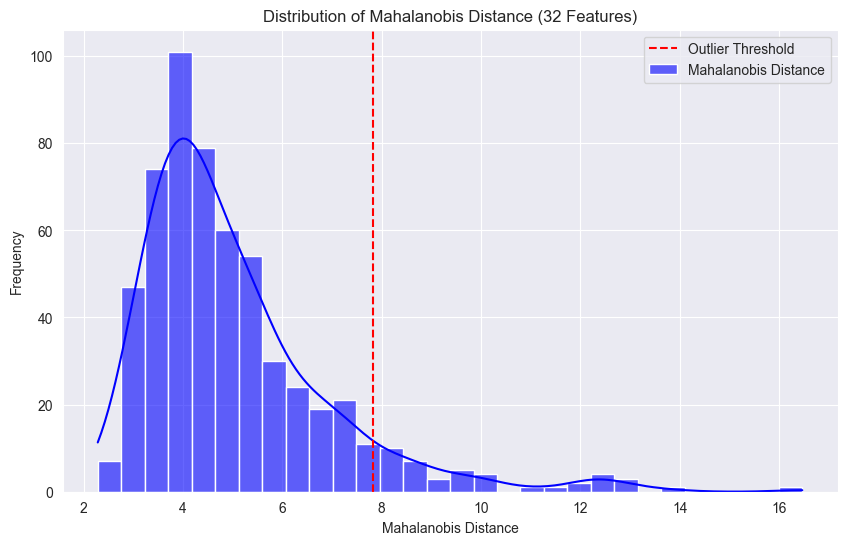

Number of Outliers Detected: 42


In [8]:
#Get Mahalanobis Distance for Examination

#Drop target column for classification
transformed_df = transformed_df.drop(columns=['diagnosis'])

#Compute Mean and Covariance Matrix for All Features
mean = transformed_df.mean(axis=0).values
cov = np.cov(transformed_df, rowvar=False)


#Compute Mahalanobis Distances
transformed_df["MahalanobisDistance"] = mahalanobis_distance_prep(transformed_df
                                                             .values,
                                                             mean,
                                                             cov)

#Threshold for Outlier Detection
threshold = stats.chi2.ppf(0.999, transformed_df.shape[1])
transformed_df["Outlier"] = (transformed_df["MahalanobisDistance"] > np.sqrt
(threshold))

#Distribution Plot of Mahalanobis Distances
plt.figure(figsize=(10, 6))
sns.histplot(transformed_df["MahalanobisDistance"], bins=30, kde=True,
             alpha=0.6,
             color="blue", label="Mahalanobis Distance")
plt.axvline(x=np.sqrt(threshold), color="red", linestyle="--",
            label="Outlier Threshold")
plt.title("Distribution of Mahalanobis Distance (32 Features)")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Number of Outliers Detected: {transformed_df['Outlier'].sum()}")

---
## Model Development - Classification
Classification of malignant vs. benign tumors is the goal of the dataset and
attempts to use the features to predict whether a patient has a benign or
malignant tumor.

### Target Selection and Pipeline

In [9]:
#Custom function for pipeline creation that can be used for all ML types
def pipeline_creation(original_df, expon_columns, target_column,
                      no_target=False,
                      scale_y=False):

    #Custom Transformations
    column_names = original_df.drop(columns=[target_column]).columns
    expon_col_indices = [column_names.get_loc(col) for col in expon_columns]


    boxcox_transformer = FunctionTransformer(func=boxcox_transformation_array,
                                             kw_args={'columns_to_transform':
                                                          expon_col_indices},
                                             validate=False)

    #If data is used for clustering, keep all features and don't split
    if no_target:
        X = original_df.copy()

        #Define pipeline
        pipeline = Pipeline([
            ('boxcox_transform', boxcox_transformer),
            ('scaler', StandardScaler())
        ])

        #Apply outlier removal
        X_train_no_outliers, outlier_mask = mahalanobis_outlier_removal(X)

        #Fit pipeline
        X_train_clean = pipeline.fit_transform(X_train_no_outliers)

        #Convert to numpy array
        X = np.asarray(X)

        return X_train_clean, None, None, None, None

    #Split into Features and Target
    X = original_df.drop(columns=[target_column])
    y = np.asarray(original_df[target_column])

    #If using regression, scale the target variable
    if scale_y:
        y_scaler = StandardScaler()
        y = y_scaler.fit_transform(y.reshape(-1, 1))
    else:
        y_scaler = None

    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)

    #Convert to numpy arrays
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)

    #Define pipeline
    pipeline = Pipeline([
        ('boxcox_transform', boxcox_transformer),
        ('scaler', StandardScaler())
    ])

    #Remove outliers
    X_train_no_outliers, outlier_mask = mahalanobis_outlier_removal(X_train)

    #Fit the pipeline
    X_train_clean = pipeline.fit_transform(X_train_no_outliers)

    #Transform test data
    X_test_clean = pipeline.transform(X_test)

    #Get only y-values from non-outliers
    y_train_clean = y_train[outlier_mask]

    return X_train_clean, X_test_clean, y_train_clean, y_test, y_scaler

### Classification

In [10]:
#Get train and test data for classification
X_train_clean, X_test_clean, y_train_clean, y_test, y_scaler = (
    pipeline_creation(original_df, expon_columns, 'diagnosis', scale_y=False))

In [11]:
#Instantiate Random Forest Classifier
rf = RandomForestClassifier(n_estimators=250, random_state=42)

rf.fit(X_train_clean, y_train_clean)

#Predict from test data
y_pred = rf.predict(X_test_clean)

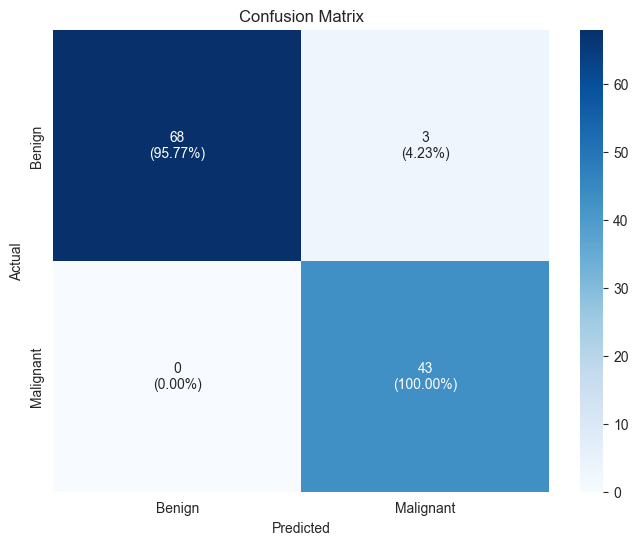

In [12]:
#Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

labels = np.array([[f"{count}\n({proportion:.2%})" for count, proportion in
                    zip(row_counts, row_proportions)]
                   for row_counts, row_proportions in zip(cm, cm_normalized)])


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
#Get model scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
Accuracy: {accuracy:.4%}
Precision: {precision:.4%}
Recall: {recall:.4%}
F1 Score: {f1:.4%}
""")


Accuracy: 97.3684%
Precision: 93.4783%
Recall: 100.0000%
F1 Score: 96.6292%



### Classification Overview
Given the results, a Random Forest classifier has high predicting power for
`diagnosis` and has an excellent recall score to the point that there were no
malignant tumors that were mislabeled as benign.  This is exceptionally
important because it would mean that all of the patients with malignant
tumors would receive the treatment they need, while only a handful of patients
with benign tumors would receive unnecessary treatment.

---
## Model Development - Regression
The dataset was not built with regression in mind, but accurate regression
inference can be achieved for a few of the features, especially given the standard error and
worst reading for each feature.  This section examines `radius_mean` as a
regression target.

In [14]:
#Get train and test data for regression
X_train_clean, X_test_clean, y_train_clean, y_test, y_scaler = (
    pipeline_creation(original_df, expon_columns, 'radius_mean',
                      no_target=False, scale_y=True))

In [15]:
#Instantiate Linear Regression Model
model = LinearRegression()
model.fit(X_train_clean, y_train_clean)

#Predict on test data
y_pred = model.predict(X_test_clean)

In [16]:
#Calculate Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"""
Mean Squared Error: {mse:.4f}
Root Mean Squared Error: {rmse:.4f}
Mean Absolute Error: {mae:.4f}
R-squared Score: {r2:.4f}
""")


Mean Squared Error: 0.0007
Root Mean Squared Error: 0.0255
Mean Absolute Error: 0.0184
R-squared Score: 0.9993



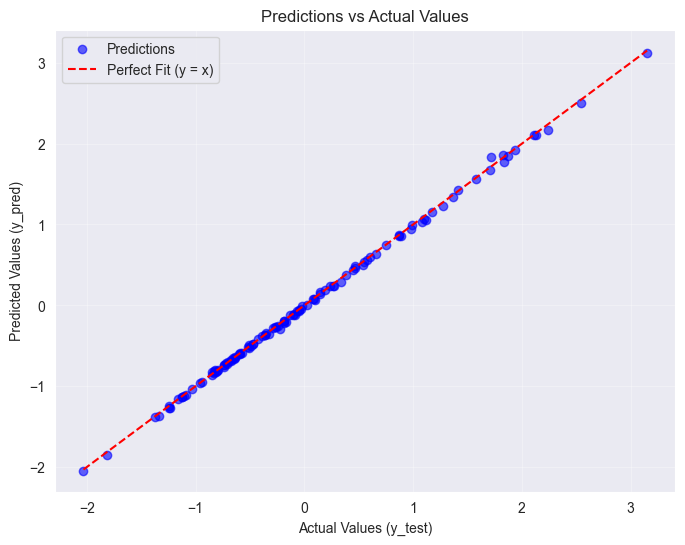

In [17]:
#Plot Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="blue", alpha=0.6, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red",
         linestyle="--", label="Perfect Fit (y = x)")
plt.title("Predictions vs Actual Values")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### Regression Overview
While not the original intention of the dataset, the evaluation
metrics suggest that regression could effectively
 be used to predict the `radius_mean` of each tumor.  This would be
 beneficial in replacing any faulty or absent data in subsequent datasets.

---
## Model Development - Clustering
A clustering algorithm can be applied on all of the data and can segment
different tumors into types based on their features and diagnosis.

In [18]:
#Get train data for clustering
X_train_clean, X_test_clean, y_train_clean, y_test, y_scaler = (
    pipeline_creation(original_df, expon_columns,'radius_mean', no_target=True,
scale_y=True))

Text(0.5, 0, 'Number of Clusters (k)')

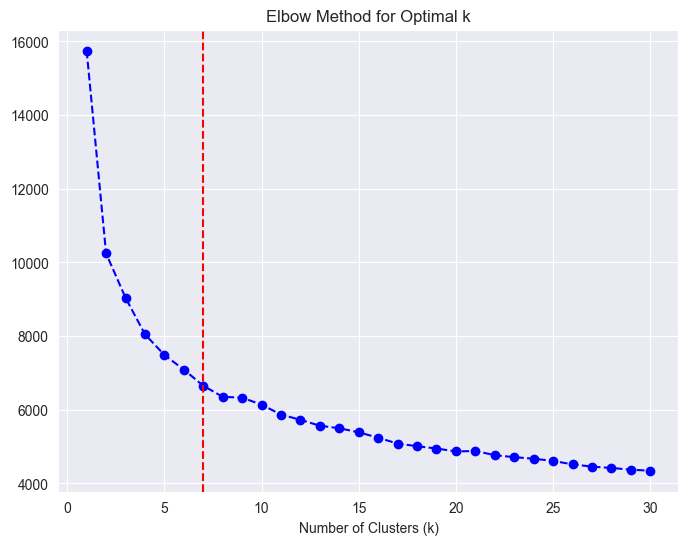

In [19]:
#Find the best K value using the Knee Methodology
inertias = []
k_range = range(1, 31)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_clean)
    inertias.append(kmeans.inertia_)

knee_locator = KneeLocator(k_range, inertias, curve='convex',
                           direction='decreasing')

optimal_k = knee_locator.knee

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, marker="o", linestyle="--", color="b",
         label="Inertia")
plt.axvline(optimal_k, color="r", linestyle="--",
            label=f"Optimal k = {optimal_k}")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")


In [20]:
#Use optimal K to fit the train data
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(X_train_clean)
labels = kmeans_optimal.labels_
centroids = kmeans_optimal.cluster_centers_

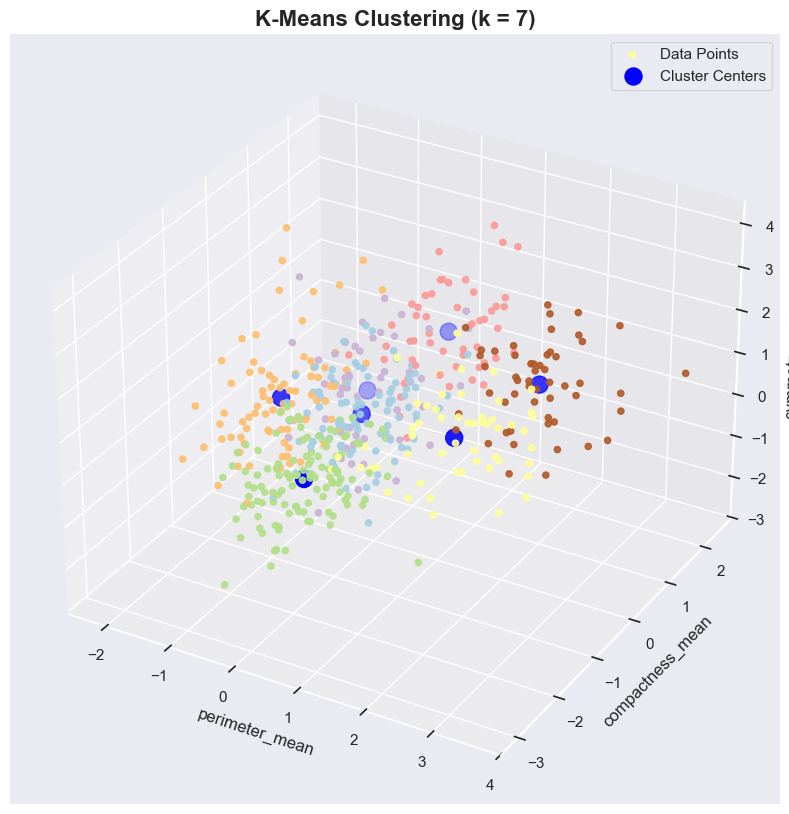

In [21]:
#Plot Clusters on 3 Features
sns.set(style="darkgrid")

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="3d")

# Define the features to plot
features_to_plot = [3, 6, 9]  # Index of features you want to visualize

# Scatter plot for clustered data points
scatter = ax.scatter(
    X_train_clean[:, features_to_plot[0]],  # X-axis
    X_train_clean[:, features_to_plot[1]],  # Y-axis
    X_train_clean[:, features_to_plot[2]],  # Z-axis
    c=labels,  # Use cluster labels for color coding
    cmap=sns.color_palette("Paired", as_cmap=True),  # Use Seaborn's husl
    # colormap
    alpha=0.9,  # Set transparency
    label="Data Points"
)

# Plot cluster centers
ax.scatter(
    centroids[:, features_to_plot[0]], centroids[:, features_to_plot[1]],
    centroids[:, features_to_plot[2]],
    c="blue", marker="o", s=150, label="Cluster Centers"
)

feature_names = [original_df.columns[i] for i in features_to_plot]
# Add titles, labels, and legend
ax.set_title(f"K-Means Clustering (k = {optimal_k})", fontsize=16,
             fontweight="bold")
ax.set_xlabel(f"{feature_names[0]}", fontsize=12)
ax.set_ylabel(f"{feature_names[1]}", fontsize=12)
ax.set_zlabel(f"{feature_names[2]}", fontsize=12)
ax.legend()
plt.show()


#### Clustering Overview
As shown above, the clustering algorithm effectively separated the data into
7 distinct categories.  This could be used for null imputation methods in
future datasets or could be used by researchers to determine subtypes of
benign or malignant tumors.

---
## Challenges

There were several challenges with this dataset.  While there were no nulls,
many of the features exhibited exponential distributions and had to be
manipulated to achieve a more Gaussian distribution, which are often
preferred by machine learning models.  As well, the steps in the process
needed to be carefully examined to account for data leakage and
reproducability.  For instance, Mahalanobis Outlier removal needed to be
performed *before* Box-Cox transformations and scaling on the data,
and could only be performed on the training data, lest outlier gets removed
from the test data, which is not recommended.

Another challenge with the Mahalanobis Outlier removal, and any outlier
removal in general, pertains to the clustering algorithm.  The clustering
model was trained using data with outliers removed.  However, when attempting
 to predict labels for the entirety of the data, the clusters wildly differed
  from the original training data.  This is because the Box-Cox
  transformation uses the data passed to it in its entirety to change the
  distribution.  If outliers are removed, the transformation will look
  different than if they are left in place, leading to different metrics for
  each feature, which would then get passed to the StandardScaler, changing
  the metrics even further from what the clustering model expects.

## Insights
While classification is the primary goal of the dataset, regression could be
used for null imputation or erroneous data handling.  Clustering can also be
beneficial for separating the tumors into subtypes for further examination.
There were no categorical variables, outside of the binary `diagnosis`
feature, and the prediction could benefit from additional features related to
 age, sex, smoking status, location of the tumor, etc.